In [16]:
from taildropout import TailDropout
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(2)
%matplotlib inline

### Basics & properties : Comparison to regular dropout

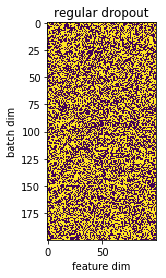

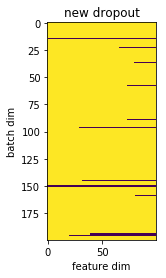

In [5]:
x = torch.ones(200,100)
y = nn.Dropout(0.5)(x)
plt.imshow(y);plt.ylabel('batch dim');plt.xlabel('feature dim')
plt.title('regular dropout')
plt.show()

y = TailDropout(1e-3)(x)
plt.imshow(y);plt.ylabel('batch dim');plt.xlabel('feature dim')
plt.title('new dropout')
plt.show()

##### There's three modes:
* `.train()` (default)
* `.eval()`
* `deterministic` 

In [6]:
cdropout = TailDropout()
# Train (randomly choose how many features to keep for each batch)
y = cdropout(x)
assert ~y.equal(x)

# Eval (keep all features)
cdropout.eval()
y = cdropout(x)
assert y.equal(x)

# Deterministic (keep first `dropout start` features)
y = cdropout(x,dropout_start = 10)
assert y[:,10:].sum()==0
assert y[:,:10].equal(y[:,:10])

You can choose which channel (`dropout_dim`) that should be sequentialy dropped out over, and witch dimension that should yield an individual random mask (`batch_dim`)

In [7]:
# TailDropout(p=0.5, batch_dim=0, dropout_dim = -1) # <- default
TailDropout(p=0.5, batch_dim=1, dropout_dim = 2)(torch.ones(3,2,10))>0

tensor([[[ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  1,  1,  1,  0,  0,  0,  0,  0,  0]],

        [[ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  1,  1,  1,  0,  0,  0,  0,  0,  0]],

        [[ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  1,  1,  1,  0,  0,  0,  0,  0,  0]]], dtype=torch.uint8)

## Details: Distribution of amount of used nodes
To make it simple, the chosen `k` is set to follow a truncated exponential distribution, but this could be anything really.

* Compared to regular dropout; more often is all neurons used
* Compared to regular dropout all neurons have different dropout-probability
* The probability of very few neurons used is vanishing with regular dropout while existant (but small) with this type
* If neuron `j` is being open it implies that neuron `j-1` is open, so there's `K` subsets of nodes total (vs $2^K$ for regular dropout) with K the number of features.

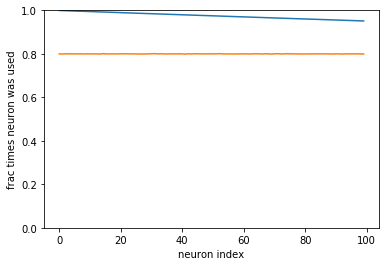

median  80.0 100.0
mean  79.98899 97.51819


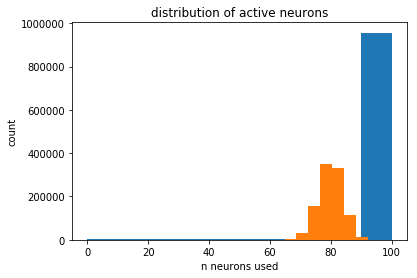

In [15]:
dropout = nn.Dropout(0.2)
cdropout = TailDropout(1e-3)
n = 1000000
n_features = 100
x = torch.ones([n,n_features])

y = (dropout(x)>0).float().float()
yc = cdropout(x)

plt.plot(yc.mean(0).numpy(),label='contiguous')
plt.plot(y.mean(0).numpy(),label='regular')
plt.ylim(0,1)
plt.ylabel('frac times neuron was used')
plt.xlabel('neuron index')
plt.show()

n_active,n_activec = y.sum(1).data.numpy(),yc.sum(1).data.numpy()
plt.hist(n_activec)
plt.hist(n_active)
print('median ',np.median(n_active),np.median(n_activec))
print('mean ',np.mean(n_active),np.mean(n_activec))
plt.xlabel('n neurons used')
plt.ylabel('count')
plt.title('distribution of active neurons')
plt.show()

# from statsmodels.distributions.empirical_distribution import ECDF
# p = np.linspace(0,1,100)

# ecdf = ECDF(yc.mean(1))
# plt.plot(p*n_features,ecdf(p))

# ecdf = ECDF(y.mean(1))
# plt.plot(p*n_features,ecdf(p))

# plt.title('distribution of active neurons')
# plt.ylabel('ecdf')
# plt.xlabel('n neurons used')
# plt.show()


# Full training example
Learn to predict random scalars using 66 random feature values. Apply dropout on the 100 hidden layer.

Task is to to overfit and just separate 1000 points in space.

[For more about the ancient concept of scree-plots](http://www.janda.org/workshop/factor%20analysis/SPSS%20run/SPSS08.htm)

Model(
  (linear1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): TailDropout(p=0.2, batch_dim=0, dropout_dim=-1)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)


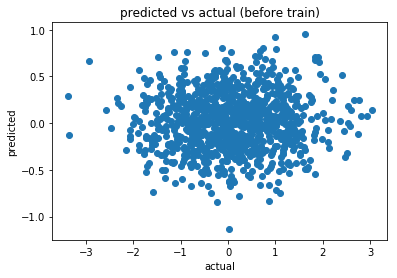

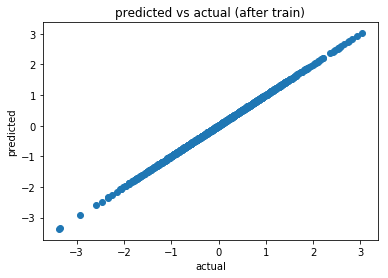

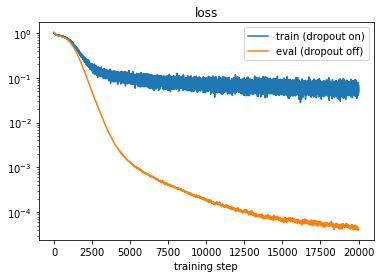

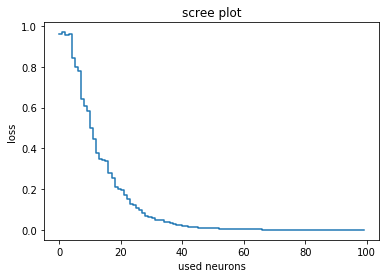

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
from taildropout import TailDropout
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(2)

n = 1000
n_input = 50
n_hidden = 100

y = torch.randn([n,1])
x = torch.randn([n,n_input])

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(n_input,n_hidden)
        self.dropout = TailDropout(0.2)
        self.linear2 = nn.Linear(n_hidden,1)
    def forward(self, x, dropout_start = None):
        x = self.linear1(x).tanh()
        x = self.dropout(x,dropout_start)
        x = self.linear2(x)
        return x

losses = []
losses_eval = []
model = Model()
print(model)
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4) 
criterion = nn.MSELoss()

model.eval()
y_pred = model(x)
model.train()
plt.scatter(y.data.numpy().squeeze(),y_pred.data.numpy().squeeze())
plt.title('predicted vs actual (before train)');plt.xlabel('actual');plt.ylabel('predicted')
plt.show()

plt.show()
for epoch in range(20000):
    optimiser.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimiser.step()
    
    losses.append(loss.data.numpy())    
    model.eval()
    losses_eval.append(criterion(model(x), y).data.numpy())
    model.train()
    
model.eval()
y_pred = model(x)
model.train()
plt.scatter(y.data.numpy().squeeze(),y_pred.data.numpy().squeeze())
plt.title('predicted vs actual (after train)');plt.xlabel('actual');plt.ylabel('predicted')
plt.show()

plt.semilogy(losses,label='train (dropout on)')
plt.semilogy(losses_eval,label='eval (dropout off)')
plt.legend()
plt.title('loss')
plt.xlabel('training step')
plt.show()

# Evaluate model with only 1,2,...,all first neurons.
scree_values = []
for n_used in range(n_hidden):
    y_pred = model(x,dropout_start=n_used)
    loss = criterion(y_pred, y)
    scree_values.append(loss.data.numpy())

plt.plot(scree_values,linestyle='steps-post')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('used neurons')
plt.title('scree plot')
plt.show()

# So it's very marginal improvements of using >40 hidden units.

### Also, dropout probability is pretty calibrated:

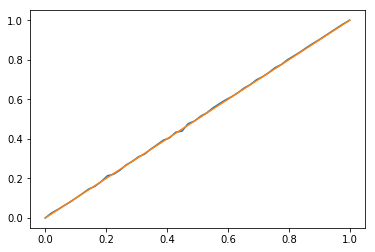

In [17]:
res = []
for p in np.linspace(0,1,50):
    res.append([p,1-TailDropout(p)(torch.ones(10000,200)).mean().data.numpy()])
plt.plot(np.stack(res)[:,0],np.stack(res)[:,1])
plt.plot([0,p],[0,p])